In [111]:
%load_ext autoreload
%autoreload 2


import numpy as np
import pandas as pd

from sksurv.util import Surv
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# Our very own survLime!
import survLime
from survLime.utils.generic_utils import fill_matrix_with_total_times
from survLime.datasets.load_datasets import Loader 
from survLime import survlime_tabular


loader = Loader(dataset_name='udca')
x,events, times = loader.load_data()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/carlos.hernandez/dl/lib/python3.8/site-packages/pandas/core/series.py:4530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [112]:
#y = Surv.from_arrays(events, time)
#X_train, X_test, y_train, y_test = train_test_split(x.copy(), y, test_size=0.05, random_state=1)
#X_val, X_test, y_val, y_test = train_test_split(X_test.copy(), y_test, test_size=0.5, random_state=1)
#scaler = StandardScaler()

#X_train_processed = pd.DataFrame(data=scaler.fit_transform(X_train, y_train),
#                                 columns=X_train.columns, index=X_train.index)



#X_test_t = pd.DataFrame(data=scaler.transform(X_test),
#                                 columns=X_test.columns, index=X_test.index)

#print(hasattr(scaler, "n_features_in_"))
train, val, test = loader.preprocess_datasets(x, events, times)
events_train = [x[0] for x in train[1]]
times_train  = [x[1] for x in train[1]]

events_val = [x[0] for x in val[1]]
times_val  = [x[1] for x in val[1]]

events_test = [x[0] for x in test[1]]
times_test  = [x[1] for x in test[1]]

#y_train = Surv.from_arrays(events_train, times_train)
#y_val   = Surv.from_arrays(events_val, times_val)
#y_test  = Surv.from_arrays(events_test, times_test)

In [113]:
model = CoxPHSurvivalAnalysis()
model = RandomSurvivalForest()
model.fit(train[0], train[1])
model.score(train[0], train[1])

0.9708265802269044

In [114]:
def kernel(d, kernel_width):
    return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2)) 
len(set(times_train))
set(times_test) - set(times_train)
max(times_test)
#max(times_train)

1834.0

In [120]:
from sksurv.nonparametric import nelson_aalen_estimator
from functools import partial
import cvxpy as cp
from math import log
import timeit
import sklearn

# Step one
Ho_t_ = nelson_aalen_estimator(events_train, times_train)[0] # Unique times [0]; CHF [1]


columns = test[0].columns.tolist()
num_pat = 500

# Step two
explainer = survlime_tabular.LimeTabularExplainer(train[0], target_data=train[1], feature_names=columns, class_names=None,
                                                   categorical_features=None, verbose=True, mode='regression', discretize_continuous=False)

synthetic_data = explainer.data_inverse(test[0].iloc[0], num_pat) # At [0] we have the data and at [1]
                                                        #the inverse, see what is this
    
# Third step: Obtain the prediction for the synthetic data 
H_i_j = model.predict_cumulative_hazard_function(synthetic_data[1]) # X_test_t -> [371, num_features]
times_to_fill = list(set(times_train)); times_to_fill.sort()

H_i_j[0]
H_i_j_wc = [fill_matrix_with_total_times(times_to_fill, x.y, list(x.x)) for x in H_i_j]

/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(


## Code trials to have it all on the explainer


In [78]:
#H_i_j_wc, weights, log_correction, H_i_j_wc, H0_t_, scaled_data = explainer.explain_instance(

In [121]:
kernel_fn = partial(kernel, kernel_width=5)

# We need to do the line 362 from survlime_tabular (scale the data)
scaled_data = synthetic_data[0] # We need to scale this
scaled_data_ = (scaled_data - explainer.scaler.mean_) / explainer.scaler.scale_
distances = sklearn.metrics.pairwise_distances(
            scaled_data,
            scaled_data[0].reshape(1,-1), # <-- Point of inquiry
            metric = 'euclidean').ravel()
weights = kernel_fn(distances)

In [122]:
scaled_data[0]

array([1.08924015, 0.68090848, 1.86215849, 0.99380799])

1.0

In [123]:
start_time = timeit.default_timer()
# code you want to evaluate
timeit.default_timer() - start_time

epsilon = 0.00000001
n = 9 # For now we are only using 3 features
num_times = len(set(times_to_fill))-1
b = cp.Variable(n)


# We are having Conconcave problems here!!
cost = [weights[k]*cp.sum_squares((log(H_i_j_wc[k][j]+epsilon) - log(Ho_t_[j]+epsilon) - b @ scaled_data[k]))\
        for k in range(num_pat) for j in range(num_times)] # *(times_to_fill[j+1]-times_to_fill[j])
#cost = [weights[k]*cp.norm((log(H_i_j_wc[k][j]+epsilon) - log(Ho_t_[j]+epsilon) - b @ scaled_data[k]),'inf') \
#                                            for k in range(num_pat) for j in range(num_times)]
print(f'time creating the cost list {timeit.default_timer() - start_time}')

start_time = timeit.default_timer()
cost_sum = cp.sum(cost)

print(f'time summing the cost list {timeit.default_timer() - start_time}')
start_time = timeit.default_timer()

prob = cp.Problem(cp.Minimize(cost_sum))


opt_val = prob.solve(verbose=True)
print(f'time solving the problem {timeit.default_timer() - start_time}')
b.value

NameError: name 'v' is not defined

/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=5.51205e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=7.75565e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=5.68509e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=3.1072e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.p

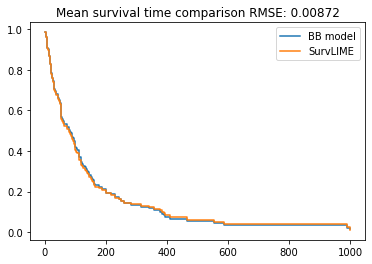

In [82]:
from survLime.utils.generic_utils import compare_survival_times

compare_survival_times(model, b.value, X_train_processed, y_train, X_train_processed)